# Developing the scraping codes to get the desired values for investing decisions

## Import Libraries

In [2]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Plan
__When to invest?__
- __A day after the annual report is published__. Because we need the data from the latest annual report to decide if we are going to invest in the stock for _this_ year.

__Features:__
1. Buy Price (it is the open price for the next candle after the day the annual report became available)
2. % change from 52Wk High (expecting Buy Price is lower than 52 Wk High, so there is room for price appreciation during the investment period)
3. % change from 52Wk Low (expecting Buy Price is at least 20% above it, because closer to it might indicate market or stock weakness for whatever reason)

  From the annual report:
4. Revenue growth (relative to the previous year)
5. Net income growth (relative to the previous year)
6. EPS
7. Debt Ratio (total debt over total assets)

__Target:__ The __maximum profit__ gained _within_ the next 260 days (52 weeks * 5 trading days) after buying the stock.

NOTE: Because we are still developing the codes, our analysis will only focus on 2021 to 2022 but for as many as stocks as possible. That is, we need the annual report published sometime in 2021. Our selling day is WITHIN the next 260 days from the buying day.

## Determine the day of the annual report publication

We will use a single stock first to develop our codes. Let's use Microsoft (MSFT) stock.

In [4]:
# Define the stock ticker object

stock = yf.Ticker("MSFT")

In [ ]:
# Get the date of the annual report publication for our desired year (2021)

for date_item in stock.income_stmt.columns.tolist():
  if date_item.year == 2021:
    publication_date = date_item.date()

print(publication_date)

2021-06-30


## Determine the open price (our buy price) of the next trading day after the publication_date

In [ ]:
# Get 10-year historical daily prices

hist = stock.history(interval='1d', period='10y')
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2013-10-07 00:00:00-04:00,28.137134,28.229250,27.802170,27.885910,35069300,0.0,0.0
2013-10-08 00:00:00-04:00,27.894286,27.911034,27.467202,27.643059,41017600,0.0,0.0
2013-10-09 00:00:00-04:00,27.693312,27.927787,27.601196,27.693312,35878600,0.0,0.0
2013-10-10 00:00:00-04:00,27.894292,28.379991,27.852418,28.271126,42875100,0.0,0.0
2013-10-11 00:00:00-04:00,28.204120,28.589330,28.204120,28.580957,30033300,0.0,0.0


In [ ]:
# Make the date row_index column as normal dataframe column

hist = hist.reset_index()
hist.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2013-10-07 00:00:00-04:00,28.137134,28.229250,27.802170,27.885910,35069300,0.0,0.0
1,2013-10-08 00:00:00-04:00,27.894286,27.911034,27.467202,27.643059,41017600,0.0,0.0
2,2013-10-09 00:00:00-04:00,27.693312,27.927787,27.601196,27.693312,35878600,0.0,0.0
3,2013-10-10 00:00:00-04:00,27.894292,28.379991,27.852418,28.271126,42875100,0.0,0.0
4,2013-10-11 00:00:00-04:00,28.204120,28.589330,28.204120,28.580957,30033300,0.0,0.0


In [ ]:
# Transform the 'Date' column from timestamp to date string

hist['Date'] = hist['Date'].dt.date
hist.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2013-10-07,28.137134,28.229250,27.802170,27.885910,35069300,0.0,0.0
1,2013-10-08,27.894286,27.911034,27.467202,27.643059,41017600,0.0,0.0
2,2013-10-09,27.693312,27.927787,27.601196,27.693312,35878600,0.0,0.0
3,2013-10-10,27.894292,28.379991,27.852418,28.271126,42875100,0.0,0.0
4,2013-10-11,28.204120,28.589330,28.204120,28.580957,30033300,0.0,0.0


In [ ]:
# Get the row position of the publication_date

condition = hist['Date'] == publication_date
publication_row_index = (hist.index[condition].tolist())[0]
publication_row_index

1946

In [ ]:
# Get the day of buying

buy_date = hist[['Date']].iloc[publication_row_index+1, 0]
buy_date

datetime.date(2021, 7, 1)

In [ ]:
# Finally, determine the Buy Price

condition = hist['Date'] == buy_date
buy_price = hist[condition].iloc[0, 1]
buy_price

264.3064797386174

## Plot historical prices (just to compare the general shape to YFinance chart or from any other sites)


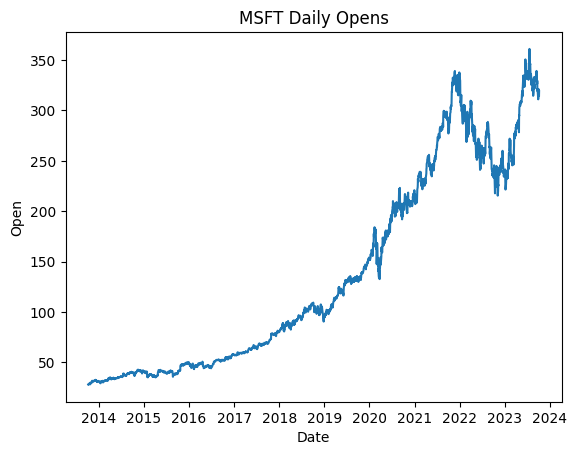

In [ ]:
sns.lineplot(x='Date', y='Open', data=hist)
plt.title('MSFT Daily Opens')
plt.show()

## Determine the recent 52-Wk High and 52-Wk Low relative to the buy candle

NOTE: One week of trading days is 5 days (Mon to Fri). So 52 weeks is 52*5 = 260 days.

In [ ]:
# Get the maximum High

stock_52WHigh = hist['High'].iloc[publication_row_index-260 : publication_row_index].max()
print('52-Wk High:', stock_52WHigh)

# Get the minimum Low
stock_52WLow = hist['Low'].iloc[publication_row_index-260 : publication_row_index].min()
print('52-Wk Low:', stock_52WLow)

52-Wk High: 266.3063309962854
52-Wk Low: 187.9230773790825


## Get the % change between the Buy Price and the 52Wk High and between the Buy Price and 52Wk Low

In [ ]:
change_from_52WHigh = round(100*(buy_price - stock_52WHigh)/stock_52WHigh, 2)
print('% Change from 52Wk High:', change_from_52WHigh, "%")

change_from_52WLow = round(100*(buy_price - stock_52WLow)/stock_52WLow, 2)
print('% Change from 52Wk Low:', change_from_52WLow, "%")

% Change from 52Wk High: -0.75 %
% Change from 52Wk Low: 40.65 %


# Calculate the annual growth for Net Income and Revenue

In [ ]:
# Get the income statement dataframe
from datetime import timedelta
income_statement = stock.income_stmt[[publication_date, publication_date-timedelta(days=365)]]


# Select only the records for 'Net Income' and 'Total Revenue'

condition = (income_statement.index == 'Net Income') | (income_statement.index == 'Total Revenue')
income_and_revenue = income_statement[condition]
income_and_revenue

,2021-06-30,2020-06-30
Net Income,61271000000.0,44281000000.0
Total Revenue,168088000000.0,143015000000.0


In [ ]:
# Compute Annual Net Income Growth

net_income_growth = round(100*(income_and_revenue.iloc[0,0]-income_and_revenue.iloc[0,1])/income_and_revenue.iloc[0,1], 2)

print('Annual Net Income Growth:', net_income_growth, '%')

Annual Net Income Growth: 38.37 %


In [ ]:
# Compute Annual Revenue Growth

revenue_growth = round(100*(income_and_revenue.iloc[1,0]-income_and_revenue.iloc[1,1])/income_and_revenue.iloc[1,1], 2)

print('Annual Revenue Growth:', revenue_growth, '%')

Annual Revenue Growth: 17.53 %


## Determine the Earnings Per Share (Basic EPS) from the Annual Report

In [ ]:
EPS = income_statement.loc['Basic EPS', str(publication_date)]
EPS

8.12

# Get the Debt Ratio

In [ ]:
annual_balance_sheet = stock.balance_sheet[[publication_date]]

In [ ]:
condition = (annual_balance_sheet.index == 'Total Debt') | (annual_balance_sheet.index == 'Total Assets')

annual_balance_sheet[condition]

,2021-06-30
Total Debt,67775000000.0
Total Assets,333779000000.0


In [ ]:
# Compute Debt Ratio

total_debt = annual_balance_sheet.loc['Total Debt', str(publication_date)]
total_assets = annual_balance_sheet.loc['Total Assets', str(publication_date)]

debt_ratio = round(total_debt/total_assets, 4)

print('Debt Ratio:', debt_ratio)

Debt Ratio: 0.2031


## Finally, get the highest profit from Buy Price within the next 260 trading days (from the buying day)



In [ ]:
highest_sell_price = hist['High'].iloc[publication_row_index: publication_row_index+260].max()
max_profit = round(100*(highest_sell_price-buy_price)/buy_price, 2)

print('Highest profit (before tax and commission):', max_profit, '%')

Highest profit (before tax and commision): 30.18 %


# Automating all the previous processes inside a Python Function

In [ ]:
def scrape_values(stocks, years):
  '''A function that scrapes the desired values from Yahoo! Finance for investing analysis.'''

  '''The result is one list of lists. Every list has 10 items, which are (in order):
  ['Stock', 'Buy-Date', 'Buy-Price', 'Pct-from-52WkHigh', 'Pct-from-52WkLow',
  'Annual-Net-Income-Growth', 'Annual-Revenue-Growth', 'EPS', 'Debt-Ratio', 'Max-Profit'].
  The Max-Profit is the highest profit from the Buy-Price within the next 260 trading days.'''

  # Import libraries
  import yfinance as yf
  import pandas as pd

  # Create the main container for this function
  list_of_lists = []

  for year in years:
    for symbol in stocks:
      # Initial empty container for values for EACH stock
      stock_list = []

      try:
        # Append the symbol of the stock to its list container
        stock_list.append(symbol)

        # Define the stock
        stock = yf.Ticker(symbol)

        # Get the publication date for the annual report
        for date_item in stock.income_stmt.columns.tolist():
          if date_item.year == year:
            publication_date = date_item.date()

        # Create the dataframe for historical prices of the stock
        hist = stock.history(interval='1d', period='10y')

        # Make the Date index as normal 'Date' column
        hist = hist.reset_index()
        hist['Date'] = hist['Date'].dt.date

        # Get the row position of the publication_date in our hist dataframe
        condition = hist['Date'] == publication_date
        publication_row_index = (hist.index[condition].tolist())[0]
        publication_row_index

        # Get the day of buying
        buy_date = hist[['Date']].iloc[publication_row_index+1, 0]

        # Append the buy_date to the stock's list container
        stock_list.append(buy_date)

        # Get the Buy Price (This is the opening price of the next candle right after the publication_date)
        condition = hist['Date'] == buy_date
        buy_price = hist[condition].iloc[0, 1]

        # Append the buy_price to the stock's list container
        stock_list.append(buy_price)

        # Get the 52-Wk High relative to the buy_price
        stock_52WHigh = hist['High'].iloc[publication_row_index-260 : publication_row_index].max()

        # Get the % change of Buy Price from 52-Wk High
        change_from_52WHigh = round(100*(buy_price - stock_52WHigh)/stock_52WHigh, 2)

        # Append the change_from_52WHigh to the stock's list container
        stock_list.append(change_from_52WHigh)

        # Get the 52-Wk Low relative to the buy_price
        stock_52WLow = hist['Low'].iloc[publication_row_index-260 : publication_row_index].min()

        # Get the % change of Buy Price from change_from_52WLow
        change_from_52WLow = round(100*(buy_price - stock_52WLow)/stock_52WLow, 2)

        # Append the change_from_52WLow to the stock's list container
        stock_list.append(change_from_52WLow)

        # Get the income statement dataframe
        from datetime import timedelta
        income_statement = stock.income_stmt[[publication_date, publication_date-timedelta(days=365)]]

        condition = (income_statement.index == 'Net Income') | (income_statement.index == 'Total Revenue')
        income_and_revenue = income_statement[condition]

        # Compute the annual net income growth
        net_income_growth = round(100*(income_and_revenue.iloc[0,0]-income_and_revenue.iloc[0,1])/income_and_revenue.iloc[0,1], 2)

        # Append net_income_growth to the stock's list container
        stock_list.append(net_income_growth)

        # Compute the annual revenue growth
        revenue_growth = round(100*(income_and_revenue.iloc[1,0]-income_and_revenue.iloc[1,1])/income_and_revenue.iloc[1,1], 2)

        # Append revenue_growth to the stock's list container
        stock_list.append(revenue_growth)

        # Determine the Earnings Per Share (Basic EPS) from the income statement
        EPS = income_statement.loc['Basic EPS', str(publication_date)]

        # Append the EPS to the stock's list container
        stock_list.append(EPS)

        # Calculate the Debt Ratio
        annual_balance_sheet = stock.balance_sheet[[publication_date]]
        condition = (annual_balance_sheet.index == 'Total Debt') | (annual_balance_sheet.index == 'Total Assets')
        annual_balance_sheet[condition]

        debt_ratio = round((annual_balance_sheet.loc['Total Debt', str(publication_date)])/(annual_balance_sheet.loc['Total Assets', str(publication_date)]), 4)

        # Append the debt_ratio to the stock's list container
        stock_list.append(debt_ratio)

        # Get the highest profit within the next 260 trading days
        highest_sell_price = hist['High'].iloc[publication_row_index: publication_row_index+260].max()
        max_profit = round(100*(highest_sell_price-buy_price)/buy_price, 2)

        # Append the max_profit to the stock's list container
        stock_list.append(max_profit)

        # Append the stock_list to the list_of_lists
        list_of_lists.append(stock_list)

      except Exception:
        continue

  return list_of_lists


# Using the `scrape_values` function to produce a dataset describing multiple stocks

## Prepare the list of stocks

In [ ]:
# Access the .csv file from my GitHub which contains some basic info about NYSE stocks
# The .csv file was downloaded from https://www.nasdaq.com/market-activity/stocks/screener
# From this file we need only the list of stock symbols

url = 'https://raw.githubusercontent.com/marvin-rubia/Stock-Investing-Strategy-Analysis/main/NYSE_Stocks.csv'

df_NYSE = pd.read_csv(url)
df_NYSE.head()

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
0,A,Agilent Technologies Inc. Common Stock,$110.35,-1.320,-1.18%,3.228701e+10,United States,1999.0,1295683,Industrials,Biotechnology: Laboratory Analytical Instruments
1,AA,Alcoa Corporation Common Stock,$26.53,-0.630,-2.32%,4.734268e+09,United States,2016.0,4420430,Industrials,Aluminum
2,AAC,Ares Acquisition Corporation Class A Ordinary ...,$10.75,-0.005,-0.05%,7.586428e+08,NaN,2021.0,25516,Industrials,Metal Fabrications
3,AACT,Ares Acquisition Corporation II Class A Ordina...,$10.28,0.005,0.05%,0.000000e+00,NaN,2023.0,11456,NaN,NaN
4,AAIC,Arlington Asset Investment Corp Class A (new),$4.27,0.080,1.91%,1.250237e+08,United States,NaN,82952,Real Estate,Real Estate Investment Trusts


In [ ]:
## Focus only on US stocks

# In Yahoo! Finance, a non-US stock tends to be represented in a different symbol
# compared to its domestic symbol OR its symbol is unavailable there.

condition = df_NYSE['Country'] == 'United States'

df_NYSE_US = df_NYSE[condition]

# Save the NYSE stock symbols to a list
NYSE_stocks = df_NYSE_US['Symbol'].tolist()

print('Number of stock symbols:', len(NYSE_stocks))

Number of stock symbols: 1836


## Use the function to scrape data about the stocks

NOTE: The `yfinance` Python library can only produce annual statements from the last 3 years. For now, we will analyze stocks that have published annual reports in 2021.

Our function depends on 2020 report to calculate the growth (net income and revenue) in 2021 report and we need 260 trading days _forward_ from the buying day. So, 2021 is a nice test year for our scraping codes to get a dataset, which contains key investing indicators and relevant target variable (Max-Profit) enough for analysis and prediction.

In [ ]:
list_per_stock = scrape_values(stocks=NYSE_stocks, years=[2021])
print('Number of Stocks Scraped:', len(list_per_stock))

ERROR:yfinance:ECC           : No data found, symbol may be delisted


Number of Stocks Scraped: 1389


In [ ]:
# Have a sense of the previous result

list_per_stock[:5]

[['AA',
  datetime.date(2022, 1, 3),
  59.34549753258321,
  -2.19,
  248.97,
  -352.35,
  30.86,
  2.3,
  0.1151,
  63.01],
 ['AAIC',
  datetime.date(2022, 1, 3),
  3.5,
  -20.81,
  4.48,
  -85.95,
  -107.96,
  -0.38,
  0.1565,
  5.43],
 ['AAN',
  datetime.date(2022, 1, 3),
  23.28090558199531,
  -33.1,
  55.41,
  -141.34,
  6.37,
  3.33,
  0.2219,
  4.64],
 ['AAP',
  datetime.date(2022, 1, 3),
  228.59526307864476,
  -0.68,
  70.73,
  24.97,
  8.82,
  9.62,
  0.2765,
  1.62],
 ['AAT',
  datetime.date(2022, 1, 3),
  34.39272989281987,
  -7.17,
  42.8,
  2.82,
  9.07,
  0.47,
  0.5465,
  4.93]]

## Create a dataframe for the scraped values

In [ ]:
# Create a dataframe of the list_per_stock

df_stock_values = pd.DataFrame(data=list_per_stock,
                               columns=['Stock', 'Buy-Date', 'Buy-Price',
                                        'Pct-from-52WkHigh', 'Pct-from-52WkLow',
                                        'Annual-Net-Income-Growth', 'Annual-Revenue-Growth',
                                        'EPS', 'Debt-Ratio', 'Max-Profit'])

In [ ]:
# Check our resulting dataframe

print(df_stock_values.shape)
df_stock_values.head()

(1389, 10)


,Stock,Buy-Date,Buy-Price,Pct-from-52WkHigh,Pct-from-52WkLow,Annual-Net-Income-Growth,Annual-Revenue-Growth,EPS,Debt-Ratio,Max-Profit
0,AA,2022-01-03,59.345498,-2.19,248.97,-352.35,30.86,2.30,0.1151,63.01
1,AAIC,2022-01-03,3.500000,-20.81,4.48,-85.95,-107.96,-0.38,0.1565,5.43
2,AAN,2022-01-03,23.280906,-33.10,55.41,-141.34,6.37,3.33,0.2219,4.64
3,AAP,2022-01-03,228.595263,-0.68,70.73,24.97,8.82,9.62,0.2765,1.62
4,AAT,2022-01-03,34.392730,-7.17,42.80,2.82,9.07,0.47,0.5465,4.93


## Save the dataset as .csv file

In [ ]:
# NOTE: The following code is optional, only needed if coding via Google Colab Notebook

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the dataframe to a .csv file

df_stock_values.to_csv("/content/drive/My Drive/Colab Notebooks/2021-NYSE-Stocks-Dataset.csv",
                       index=False)

## Final Thoughts

In this Notebook, we were able to develop a Python function to get key information that are relevant to a stock investing strategy.

__Signals for Investing:__

Technical Trading Indicators:
- The position of the _current_ price relative to stock's 52-Week High and Low. These indicators are typically important for technical traders who time the market. These two features can help indicate whether the stock is near the "distribution stage" or "accumulation stage".

Growth Investing Indicators:
- Annual Net Income Growth
- Annual Revenue Growth

Value Investing Indicators:
- EPS
- Debt Ratio

__Variable for Predictive Analysis and Modeling__
- The maximum profit the investor/trader can get _if_ they buy the stock at the Buy-Price on the Buy-Date.

## My Next Plan

The next phase of this project is to develop the predictive model for the Max-Profit (via regression analysis) from the dataset that I produced. Also, I plan to collect more data from more stocks and from other years.